# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

Описание данных\
Данные геологоразведки трёх регионов находятся в файлах: \
/datasets/geo_data_0.csv.\
/datasets/geo_data_1.csv.\
/datasets/geo_data_2.csv.\
id — уникальный идентификатор скважины;\
f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);\
product — объём запасов в скважине (тыс. баррелей).\
\
Условия задачи:\
\
Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).\
При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.\
Бюджет на разработку скважин в регионе — 10 млрд рублей.\
При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.\
После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.\
Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

## Загрузка и подготовка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from numpy.random import RandomState

In [2]:
data_1 = pd.read_csv('/datasets/geo_data_0.csv')
data_2 = pd.read_csv('/datasets/geo_data_1.csv')
data_3 = pd.read_csv('/datasets/geo_data_2.csv')

In [3]:
def get_data_info(data):
    display(data.sample(10))
    display(data.info())
    display(data.describe(include='all'))
    display(data.isna().sum())
    display(data.duplicated().sum())
    display(data.corr())
    plt.rcParams['figure.figsize'] = (9, 7)
    sns.heatmap(data.corr(), annot=True, linewidths=3, linecolor='white')

,id,f0,f1,f2,product
38613,LkO3n,-0.008681,0.417443,2.102853,123.164211
18938,GXLtl,0.736656,-0.368375,0.253948,56.829188
91732,N24EI,-0.959095,0.369525,2.591265,29.067162
49390,ZYegp,-0.910290,0.120511,5.825675,146.044429
49142,UwrrE,0.022856,0.304838,5.458302,129.897561
29092,oLNk4,0.414960,-0.192932,8.572461,109.401231
26587,NUYcF,-0.993709,0.004752,0.851686,82.514532
11984,kATPm,-0.887445,0.290775,0.994160,22.433330
87194,YLnb8,0.492155,1.246989,0.984304,115.200518
62377,EWNeg,-0.354587,1.148640,6.103000,33.560544


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,id,f0,f1,f2,product
count,100000,100000.000000,100000.000000,100000.000000,100000.000000
unique,99990,NaN,NaN,NaN,NaN
top,fiKDv,NaN,NaN,NaN,NaN
freq,2,NaN,NaN,NaN,NaN
mean,NaN,0.500419,0.250143,2.502647,92.500000
std,NaN,0.871832,0.504433,3.248248,44.288691
min,NaN,-1.408605,-0.848218,-12.088328,0.000000
25%,NaN,-0.072580,-0.200881,0.287748,56.497507
50%,NaN,0.502360,0.250252,2.515969,91.849972
75%,NaN,1.073581,0.700646,4.715088,128.564089


id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

0

,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


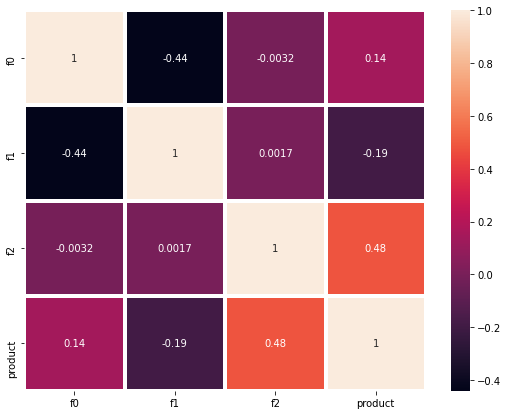

In [4]:
get_data_info(data_1)

,id,f0,f1,f2,product
61106,EcRRI,12.376046,-5.951145,2.994024,80.859783
74747,pIwhq,2.194781,-11.816815,4.000737,110.992147
36942,o8kYg,4.473688,-3.375524,2.997731,84.038886
68905,0QtmH,-14.903497,-6.948697,2.999857,84.038886
8021,mHTKz,-5.110986,-4.110421,3.998896,110.992147
89990,so8xg,-8.723533,-4.869391,4.998989,137.945408
62333,wqjgF,5.128704,-4.819091,2.001539,53.906522
61999,maTDz,8.874648,-9.142833,1.994184,53.906522
20446,kh0qn,-8.136675,-11.850237,0.005748,3.179103
48725,1dKEu,8.485000,-5.871563,-0.011562,0.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,id,f0,f1,f2,product
count,100000,100000.000000,100000.000000,100000.000000,100000.000000
unique,99996,NaN,NaN,NaN,NaN
top,bfPNe,NaN,NaN,NaN,NaN
freq,2,NaN,NaN,NaN,NaN
mean,NaN,1.141296,-4.796579,2.494541,68.825000
std,NaN,8.965932,5.119872,1.703572,45.944423
min,NaN,-31.609576,-26.358598,-0.018144,0.000000
25%,NaN,-6.298551,-8.267985,1.000021,26.953261
50%,NaN,1.153055,-4.813172,2.011479,57.085625
75%,NaN,8.621015,-1.332816,3.999904,107.813044


id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

0

,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


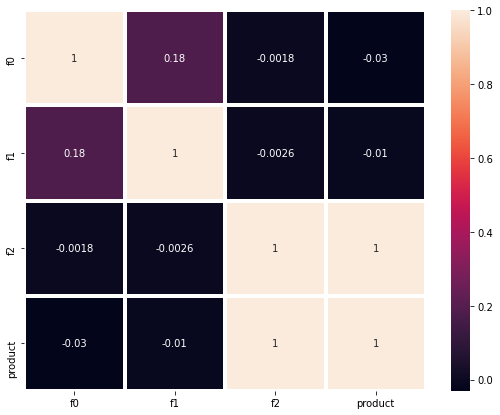

In [5]:
get_data_info(data_2)

,id,f0,f1,f2,product
36571,Yy6NU,0.720859,1.762313,6.777944,142.859922
28533,sXD1n,1.174650,-1.252004,4.501813,96.737856
10614,Kd2Bc,1.241825,-3.171119,-0.396064,84.568290
14018,YYd4j,-0.251918,-1.184372,0.103189,86.601858
55837,Hwh1c,2.241002,-0.411815,-1.064260,65.395524
14556,o6114,-4.190285,0.005829,2.882609,119.077369
9891,tk2hn,-1.822401,-0.102968,6.973978,154.194829
76205,1J8u2,1.345364,-2.716008,2.310478,87.801212
52294,AWQxW,-1.675497,0.247119,-0.059039,113.396216
48851,9UB7I,-0.852271,-2.093992,7.452740,48.346502


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,id,f0,f1,f2,product
count,100000,100000.000000,100000.000000,100000.000000,100000.000000
unique,99996,NaN,NaN,NaN,NaN
top,KUPhW,NaN,NaN,NaN,NaN
freq,2,NaN,NaN,NaN,NaN
mean,NaN,0.002023,-0.002081,2.495128,95.000000
std,NaN,1.732045,1.730417,3.473445,44.749921
min,NaN,-8.760004,-7.084020,-11.970335,0.000000
25%,NaN,-1.162288,-1.174820,0.130359,59.450441
50%,NaN,0.009424,-0.009482,2.484236,94.925613
75%,NaN,1.158535,1.163678,4.858794,130.595027


id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

0

,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


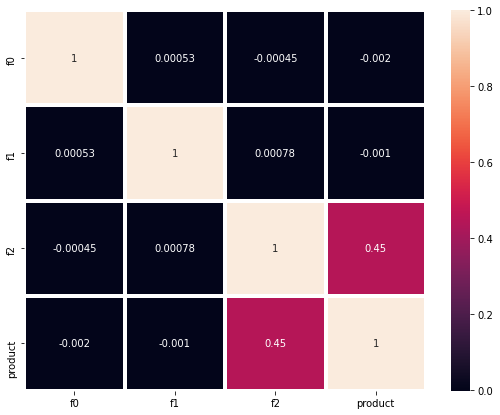

In [6]:
get_data_info(data_3)

Данные успешно загружены, пропуски и дубликаты отсутствуют. Дополнительной предобработки не требуется. В 3 совокупностях одинаковое количество данных. Признаки f0, f1, f2 во всех 3 совокупностях имеют одинаковый тип данных.  Для всех датасетов средние значения близки к медианным, значит значительных выбросов в данных нет. Корреляции между признаками практически нет. Однако для второго региона имеется зависимость продукта от признака f2.

## Обучение и проверка модели

In [7]:
def LR(data):
    features = data.drop(['id', 'product'], axis=1)
    target = data['product']
    
    features_train, features_valid, target_train, target_valid = train_test_split(
        features, target, test_size= 0.25, random_state=12345)

    scaler = StandardScaler()
    features_train = scaler.fit_transform(features_train)
    features_valid = scaler.transform(features_valid)
    
    model = LinearRegression()
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    
    rmse = mean_squared_error(target_valid, predictions_valid)**0.5
    average_stock = predictions_valid.mean()

    print('Cредний запас предсказанного сырья:', average_stock)
    print('RMSE модели:', rmse)
    return predictions_valid, target_valid.reset_index(drop=True), average_stock

In [8]:
print('Регион 1')
print('')
predictions_1, target_valid_1, average_stock_1 = LR(data_1)
print('')
print('')
print('Регион 2')
print('')
predictions_2, target_valid_2, average_stock_2 = LR(data_2)
print('')
print('')
print('Регион 3')
print('')
predictions_3, target_valid_3, average_stock_3 = LR(data_3)

Регион 1

Cредний запас предсказанного сырья: 92.59256778438035
RMSE модели: 37.5794217150813


Регион 2

Cредний запас предсказанного сырья: 68.728546895446
RMSE модели: 0.893099286775617


Регион 3

Cредний запас предсказанного сырья: 94.96504596800489
RMSE модели: 40.02970873393434


Обучив линейную регрессию на 3 тренировочных выборках, мы определили, что лучший RMSE на валидационной выборке у модели региона 2

## Подготовка к расчёту прибыли

При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.\
Бюджет на разработку скважин в регионе — 10 млрд рублей.\
При нынешних ценах один баррель сырья приносит 450 рублей дохода.\
Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.\
После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%.\
Среди них выбирают регион с наибольшей средней прибылью.

In [10]:
POINTS = 500
BEST_POINTS = 200
BUDGET = 10_000_000_000
PRICE_BARREL = 450_000
PROBABILITY = 0.025

In [11]:
volume = BUDGET / (BEST_POINTS * PRICE_BARREL)
print('Необходимый объем сырья для безубыточной разработки скважины:', round(volume, 2))

Необходимый объем сырья для безубыточной разработки скважины: 111.11


Достаточный объём сырья для безубыточной разработки новой скважины 111.11 тыс. баррелей. Средний запас сырья скважин в первом, втором и третьем регионе ниже необходимого для безубыточной разработки новой скважины.\
Нужно иметь модель, которая наиболее корректно предсказывала бы объем продукта в зависимости от известных факторов.

## Расчёт прибыли и рисков 

Функция для расчета прибыли

In [12]:
def profit(predictions, target, BEST_POINTS):
    target = target.reset_index(drop=True)
    predictions = pd.Series(predictions).reset_index(drop=True)
    probs_sorted = predictions.sort_values(ascending=False)[:BEST_POINTS]
    selected = target[probs_sorted.index]
    sum_data_sorted = selected.sum()
    return sum_data_sorted * PRICE_BARREL - BUDGET

In [13]:
print('Прибыль в 1 регионе:', round(profit(predictions_1, target_valid_1, BEST_POINTS)/ 1000000000, 4), 'млрд.рублей')
print('Прибыль в 2 регионе:', round(profit(predictions_2, target_valid_2, BEST_POINTS)/ 1000000000, 4), 'млрд.рублей')
print('Прибыль в 3 регионе:', round(profit(predictions_3, target_valid_3, BEST_POINTS)/ 1000000000, 4), 'млрд.рублей')

Прибыль в 1 регионе: 3.3208 млрд.рублей
Прибыль в 2 регионе: 2.4151 млрд.рублей
Прибыль в 3 регионе: 2.7103 млрд.рублей


In [14]:
state = RandomState(12345)
def get_values(predictions, target_valid):
    values = []
    for i in range(1000):
        target_subsample = target_valid.sample(n=POINTS, replace=True, random_state=state)
        probs_subsample = pd.Series(predictions)[target_subsample.index]
        values.append(profit(probs_subsample, target_subsample, BEST_POINTS))
    values = pd.Series(values)
    lower = values.quantile(PROBABILITY)
    upper = values.quantile(1 - PROBABILITY)
    loss = sum(values < 0) / values.count() * 100
    mean = values.mean()
    print('Средняя прибыль:', round(mean / 1000000, 4), 'млн.руб.')
    print('95%-й доверительный интервал:  от', round(lower / 1000000, 4), 'млн.руб. до', round(upper / 1_000_000, 4), 'млн.руб.')
    print('Риск убытков:', loss, '%')

In [15]:
print('Регион 1')
print('')
get_values(predictions_1, target_valid_1)
print('')
print('')
print('Регион 2')
print('')
get_values(predictions_2, target_valid_2)
print('')
print('')
print('Регион 3')
print('')
get_values(predictions_3, target_valid_3)

Регион 1

Средняя прибыль: 396.165 млн.руб.
95%-й доверительный интервал:  от -111.2155 млн.руб. до 909.7669 млн.руб.
Риск убытков: 6.9 %


Регион 2

Средняя прибыль: 461.1558 млн.руб.
95%-й доверительный интервал:  от 78.0508 млн.руб. до 862.9521 млн.руб.
Риск убытков: 0.7000000000000001 %


Регион 3

Средняя прибыль: 392.9505 млн.руб.
95%-й доверительный интервал:  от -112.2276 млн.руб. до 934.5629 млн.руб.
Риск убытков: 6.5 %


В первом и третьем регионах риск убытков больше требуемых 2.5%. Таким образом, единственным подходящим будет второй регион, средняя прибыль в котором составит 461.1558 млн.руб.

**Вывод**\
\
Мы обработали пробы нефти в трёх регионах в каждом из которых по 10 000 месторождений.\
Для прогноза по объёму запасов мы создали модель линейной регрессии по каждой из локаций. У 2 модели получились наиболее точные предсказания, показатель rmse был равен 0.89.\
Также мы рассчитали обём сырья для безубыточной разработки новой скважины(111.11 тыс. баррелей).\
Далее мы рассчитали прибыль по каждому региону. Наибольшая прибыль оказалась в 1 регионе(3.3208 млрд.рублей).\
Далее, чтобы рассчитать распределение прибыли мы применили технику Bootstrap на 1000 выборок. Таким образом,техника показала, что наиболее подходящим регионом для разработки является второй, по причине наименьшей вероятности убытка(0.7%) и наибольшей средней возможной прибыли(461.1558 млн.рублей).
